# Guided Project: Analyzing NYC High School Data
[Lev Craig](https://github.com/levcb)

## Project Overview
This is a Dataquest guided project that analyzes data from NYC-area high schools. It gathers together data from several datasets that provide information about various aspects of each school, including neighborhood, class size, race and gender demographics, and the like.

This project specifically focuses on SAT scores. Since New York City makes data on its high schools' SAT scores publicly available, we'll be able to analyze the correlations between SAT score and other factors.

## Background and Dataset Descriptions
### SAT
The SAT (Scholastic Aptitude Test) is an exam that most American high schoolers take before applying to college. The test contains three sections[<sup>1</sup>](#fn1) – critical reading, math, and writing – each of which is worth a maximum of 800 points (making the maximum possible score 2,400 points). 

### Datasets
This project uses several datasets, which are described below (links and descriptions from Dataquest).

| Dataset name and link                                                                                                       | Dataset description                                                                                                                                               |
|-----------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4)                                       | SAT scores for each high school in New York City                                                                                                                  |
| [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt)   | Attendance information for each school in New York City                                                                                                           |
| [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)                    | Information on class size for each school                                                                                                                         |
| [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)             | Advanced Placement (AP) exam results for each high school[<sup>2</sup>](#fn2) |
| [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) | The percentage of students who graduated, and other outcome information                                                                                           |
| [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)        | Demographic information for each school                                                                                                                           |
| [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)                                   | Surveys of parents, teachers, and students at each school                                                                                                         |

Together, these datasets can be used to identify correlations between SAT score and various other factors. First, however, the data need to be cleaned and combined to facilitate analysis.

<span id="fn1" style="font-size: .75em;"><sup>1</sup> Until 2005, the SAT originally contained only two of these sections – critical reading and math – for a total possible score of 1,600 points. The writing section was added in 2005 and removed again in 2016. However, since all of our data is from the period 2005–2016, only the version of the SAT that provides a score out of 2,400 points is relevant for our purposes.</span>

<span id="fn2" style="font-size: .75em;"><sup>2</sup> AP exams are offered in specific subject areas. Taking AP classes and achieving high scores on AP exams are generally considered markers of academic achievement and factor into college admissions. AP classes can also earn students college credit in a particular subject, depending on their score and the college's policies.</span>

## Setting Up Environment

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# set matplotlib to display inline
%matplotlib inline

In [2]:
# read in .csv files
files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv',
]

data = {}
for file in files:
    ds = pd.read_csv('schools/{0}'.format(file))    # files are saved in 'schools' folder
    data[file.replace('.csv', '')] = ds             # remove file extension from name, add to dictionary

In [3]:
# read in .txt files
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')     
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)    # join the two survey files

survey['DBN'] = survey['dbn']       # renaming DBN column for consistency
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s",
                "N_t", "N_p", "saf_p_11", "com_p_11",
                "eng_p_11", "aca_p_11", "saf_t_11",
                "com_t_11", "eng_t_11", "aca_t_11",
                "saf_s_11", "com_s_11", "eng_s_11",
                "aca_s_11", "saf_tot_11", "com_tot_11",
                "eng_tot_11", "aca_tot_11"]
survey = survey.loc[:, survey_fields]
data['survey'] = survey

## Adding DBN Column
Note: A school's DBN (District Borough Number) is a combination of its district number, the letter code for the borough, and the number of the school. Every NYC school has a DBN.

In [4]:
# add dbn columns
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(n):
    str_n = str(n)
    if len(str_n) == 2:
        return str_n
    elif len(str_n) == 1:
        return str_n.zfill(2)

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

## Converting SAT Score, AP Score, and Latitude/Longitude to Numeric

In [5]:
# convert SAT columns to numeric for analysis
sat_cols = ['SAT Math Avg. Score',
                   'SAT Critical Reading Avg. Score',
                   'SAT Writing Avg. Score']
for col in sat_cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors='coerce')
    
data['sat_results']['sat_score'] = data['sat_results'][sat_cols[0]] + data['sat_results'][sat_cols[1]] + data['sat_results'][sat_cols[2]]

print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


In [6]:
# extract latitude and longitude, convert to numeric
def return_lat(str_):
    latlon = str(re.findall('\(.+\)', str_))
    return latlon.split(',')[0].replace("['(", '')
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(return_lat)

def return_lon(str_):
    latlon = str(re.findall('\(.+\)', str_))
    return latlon.split(',')[1].replace(")']", '')

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(return_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(return_lon)
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

In [7]:
# convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
data['ap_2010'][cols] = data['ap_2010'][cols].apply(pd.to_numeric, errors='coerce')

## Condensing Datasets
In the next cell, we'll narrow our focus to isolate only the information we need for our analysis.

In [8]:
# condense datasets
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']            # focus only on high school
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']     # focus only on general education programs

class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

# focus only on 2011–12 school year
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

## Combining All Datasets

In [9]:
# combine datasets
combined = data["sat_results"]

datasets_merge_left = ['ap_2010', 'graduation']
for d in datasets_merge_left:
    combined = combined.merge(data[d], how='left', on='DBN')

datasets_merge_inner = ['class_size', 'demographics', 'survey', 'hs_directory']
for d in datasets_merge_inner:
    combined = combined.merge(data[d], how='inner', on='DBN')
    
# fill missing vals with means/zeroes
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Adding School District Column

In [10]:
def return_first_two(str_):     # school district is the first two characters of DBN
    return str_[0:2]

combined['school_dist'] = combined['DBN'].apply(return_first_two)

## Identifying Correlations
As a first step, we'll find the strongest positive and negative correlations between SAT score and other factors.

In [11]:
correlations = combined.corr()
correlations = correlations['sat_score']
# find top five positive and negative correlations by sorting r-values in ascending and descending order
top_neg = correlations.sort_values().dropna()
top_pos = correlations.sort_values(ascending=False).dropna()
print('Top five negative correlations:\n', top_neg.head(), '\n')
print('Top five positive correlations:\n', top_pos.head())

Top five negative correlations:
 frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
Name: sat_score, dtype: float64 

Top five positive correlations:
 sat_score                          1.000000
SAT Writing Avg. Score             0.987771
SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
white_per                          0.620718
Name: sat_score, dtype: float64


There are strong negative correlations between SAT score and:
- percentage of students receiving free or reduced lunch (`frl_percent`);[<sup>3</sup>](#fn3)
- percentage of students in a special education program (`sped_percent`);
- percentage of English language learner students (`ell_percent`); and
- percentage of Hispanic and Black students (`hispanic_per` and `black_per`, respectively)

In short, it appears that schools with higher percentages of lower-income students, special education students, students who speak English as a foreign language (EFL), and Black or Hispanic/Latino students tend to have lower average SAT scores. Special education students typically have learning or other disabilities, which is likely to impact their performance on a test like the SAT (which isn't designed with such students in mind). Similarly, EFL students may struggle with the material on the SAT, which is written entirely in English and includes some sections that are challenging even for native speakers, such as the advanced vocabulary in the critical reading section.

Lower-income students are less likely to have the resources that wealthier students do when it comes to preparing for the SAT (such as the ability to pay for private tutors, or the free time to devote to studying rather than part-time work), and the schools that they attend may be underfunded, creating additional and longer-term inequities in their quality of education.

Likewise, Black and Hispanic/Latino students are more likely to have lower family incomes and to face other forms of social and institutional discrimination, which can impact their access to resources and lead to phenomena like stereotype threat, in which a "socially premised psychological threat...arises when one is in a situation or doing something for which a negative stereotype about one's group applies" ([Steele & Aronson, 1995](https://psycnet.apa.org/record/1996-12938-001)). There is also some evidence that the SAT itself is racially biased against Black test takers (see, e.g., [Freedle, 2003](https://psycnet.apa.org/record/2003-03383-001); [Rattani, 2016](https://www.scirp.org/journal/paperinformation.aspx?paperid=70682); [Santelices & Wilson, 2010](https://www.hepg.org/her-home/issues/harvard-educational-review-volume-80-issue-1/herarticle/the-case-of-freedle,-the-sat,-and-the-standardizat)). Students who speak English as a foreign language may also be more likely to be people of color and/or low income, particularly if they or their parents are recent immigrants.

Most of the top five strongest positive correlations are fairly obvious (`sat_score` itself, followed by scores on the writing, reading, and math subsections, respectively). Let's skip these to get to more interesting correlations.

<span id="fn3" style="font-size: .75em;"><sup>3</sup> This column name isn't defined in the data dictionary provided for this dataset, and Dataquest lists it as indicating the percentage of English language learners at a given school. However, in education contexts, the acronym "FRL" typically stands for "free and reduced lunch," and other documents published by the New York Department of Education use it in this way; therefore, it's probably reasonable to conclude that that's what it means here, as well. Student eligibility for the free or reduced lunch program is determined by family income, so it may be helpful to think of this column as a proxy for socioeconomic status.</span>

In [12]:
print('Top 10 positive correlations (not SAT-related):\n', top_pos.iloc[4:14])

Top 10 positive correlations (not SAT-related):
 white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
Name: sat_score, dtype: float64


These seem to be more useful. The non–SAT-related positive correlations seem to fall into three main clusters: race (`white_per`, `asian_per`, `asian_num`, `white_num`), AP tests (`AP Test Takers`, `Total Exams Taken`, `Number of Exams with scores 3 4 or 5`), and number of students in a school (`N_s`, `N_p`, `total_students`).

- Schools with more White and Asian students—both in terms of numbers and percentages—appear to have higher SAT scores. These groups tend to have higher socioeconomic status in the United States, and predominantly White and Asian schools are often better funded than their predominantly Black and Hispanic/Latino counterparts. Accordingly, White and Asian students may be more likely to have access to study resources and to have had a high-quality education that prepared them well for the material on the SAT.
- High proportions of AP test takers and high numbers of AP exams taken are associated with higher SAT scores. A high number of good scores on AP exams[<sup>4</sup>](#fn4) is positively correlated, as well. This makes sense: As mentioned above, AP courses and tests often indicate academic achievement and typically involve more challenging material than that covered on the SAT. Students who have access to AP courses and do well on AP tests are probably more likely to do well on other tests (like the SAT), too. In addition, schools with extensive and successful AP programs may be more likely to be well funded and to have high-quality educational instruction.
- Schools with more students seem to do better on the SAT, too. This finding is somewhat counterintuitive—we might expect that small schools would do better, assuming that students would have more access to teachers and smaller class sizes—so this may be worth investigating further. Some preliminary theories:
  - Maybe larger schools are better funded and thus have a better quality of instruction.
  - Smaller schools often have smaller class sizes, but class size and total student enrollment aren't necessarily the same thing. If a larger school had smaller class sizes, or otherwise made an effort to ensure that students got a personalized and interactive education, perhaps the positive aspects of a larger school (a wider variety of classes and extracurriculars, a more diverse student body, perhaps even an SAT prep study group or workshop) would give the student an advantage when it came time to take the SAT.


Next, we'll investigate this last factor more closely using a scatterplot.


<span id="fn4" style="font-size: .75em;"><sup>4</sup> AP exams are scored from 1 to 5, where 1 is the lowest and 5 is the highest.</span>

Text(0.5, 1.0, 'School Enrollment and SAT Score Scatterplot')

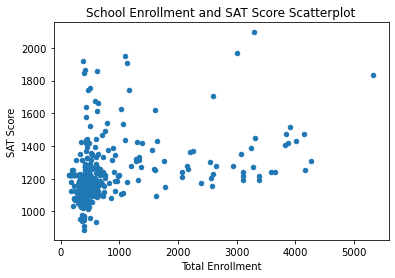

In [13]:
# plot correlations between total_enrollment and SAT score
fig = combined.plot.scatter(x='total_enrollment', y='sat_score')
fig.set_ylabel('SAT Score')
fig.set_xlabel('Total Enrollment')
fig.set_title('School Enrollment and SAT Score Scatterplot')

In [14]:
# drop DBN since it's not useful for correlations
survey_fields.remove('DBN')

Next, we'll make another plot: this time, a bar chart of the correlations between various fields in the `survey` dataset and SAT score.

Text(0.5, 1.0, 'Correlations Between Survey Fields and SAT Score')

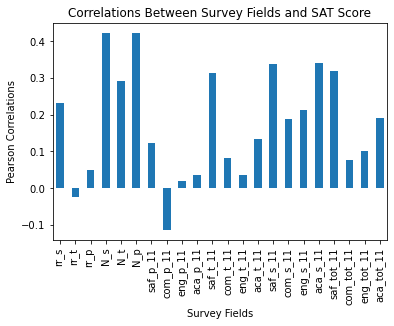

In [15]:
# plot correlations between SAT score and survey fields
fig = combined.corr()['sat_score'][survey_fields].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Survey Fields')
fig.set_title('Correlations Between Survey Fields and SAT Score')

As we might have expected, given the results of our analysis of the strongest positive correlations, the strongest positive correlations include `N_s` (number of student respondents) and `N_p` (number of parent respondents). These are likely fairly good proxies for total student enrollment; the more students answer a survey, the more students there likely are at a given school. If the survey was optional, we might also theorize that higher numbers of respondents might indicate higher student and parent engagement, which may in turn be related to academic achievement.

Other possibly notable correlations include fields related to safety and respect (`saf_s_11` [student-evaluated], `saf_t_11` [teacher-evaluated], `saf_tot_11` [total—parents, students, and teachers]), as well as student-evaluated academic expectations (`aca_s_11`). It makes sense that feeling safe and respected at school is a prerequisite for doing well academically (or, in the case of teachers, being able to teach effectively). Similarly, a school's having high academic expectations may create an environment that encourages students to push themselves to do well in school and create a culture of success. Below, we'll look more closely at student-evaluated safety scores in relation to SAT scores.

Text(0.5, 1.0, 'Safety and SAT Score Scatterplot')

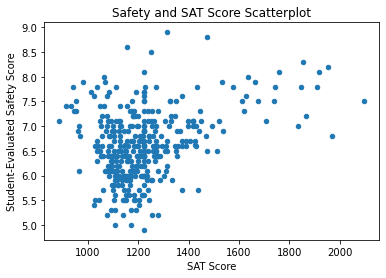

In [16]:
# plot safety score (student-evaluated) on SAT score
fig = combined.plot.scatter(x='sat_score', y='saf_s_11')
fig.set_ylabel('Student-Evaluated Safety Score')
fig.set_xlabel('SAT Score')
fig.set_title('Safety and SAT Score Scatterplot')

The correlations here don't appear to be particularly strong. However, it's possibly worth noting that there are no SAT scores above 1600 from a school with a safety score lower than ~7.

Next, we'll check whether there are differences in safety score across NYC's five boroughs: Manhattan, Brooklyn, Queens, the Bronx, and Staten Island.

In [17]:
# create pivot table of avg safety score for each borough
boro_pt = pd.pivot_table(combined, values='saf_s_11', columns='boro', aggfunc=np.mean)
print(boro_pt)

boro         Bronx  Brooklyn  Manhattan    Queens  Staten Island
saf_s_11  6.606577  6.370755    6.83137  6.721875           6.53


Overall, these seem to be pretty similar: All scores are between 6.3 and 6.9, so the distribution here isn't particularly wide. Manhattan is the safest (which is unsurprising—Manhattan is the wealthiest and most densely populated borough with a comparatively lower crime rate), and Brooklyn is the least safe (again, relatively unsurprising—Brooklyn has lower average income and higher crime rates compared with Manhattan).

Next, we'll look more closely at the correlations between race and SAT score.

Text(0.5, 1.0, 'Correlations Between Race Percentage and SAT Score')

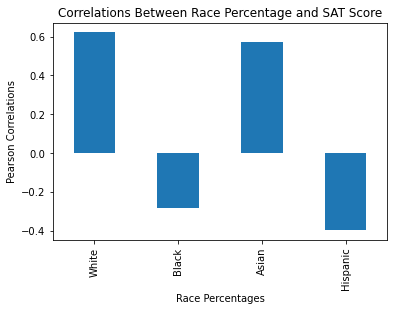

In [18]:
# plot race vs. SAT score
race_per_cols = ['white_per',
                 'black_per',
                 'asian_per',
                 'hispanic_per']
race_ticks = ['White',
                 'Black',
                 'Asian',
                 'Hispanic']
fig = combined.corr()['sat_score'][race_per_cols].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Race Percentages')
fig.set_xticklabels(race_ticks)
fig.set_title('Correlations Between Race Percentage and SAT Score')

This chart visualizes what we described above: There are positive correlations between SAT score and percentage of White and Asian students and negative correlations between SAT score and percentage of Black and Hispanic students. We'll look more closely at the correlations for Hispanic students next, as this has the strongest negative correlation.

Text(0.5, 1.0, 'Hispanic Population and SAT Score Scatterplot')

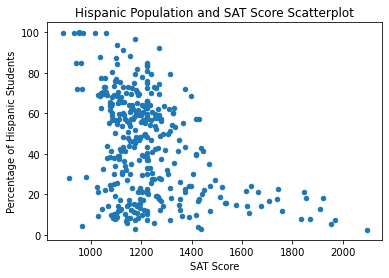

In [19]:
# scatter plot for hispanic students & sat score
fig = combined.plot.scatter(x='sat_score', y='hispanic_per')
fig.set_ylabel('Percentage of Hispanic Students')
fig.set_xlabel('SAT Score')
fig.set_title('Hispanic Population and SAT Score Scatterplot')

There's definitely a negative correlation here—schools with high Hispanic populations tend to have low SAT scores, and schools with low Hispanic populations tend to have high SAT scores. Next, we'll look at the SAT scores of the schools with the highest percentages of Hispanic students.

In [20]:
# identify schools with over 95% Hispanic students
high_his_per = combined[combined['hispanic_per'] > 95.0]
print(high_his_per.loc[:, ['SCHOOL NAME', 'hispanic_per', 'sat_score']].sort_values(by='hispanic_per'))

SCHOOL NAME  hispanic_per  \
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL          96.7   
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY          99.4   
44                       MANHATTAN BRIDGES HIGH SCHOOL          99.8   
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...          99.8   
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS          99.8   
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE          99.8   
253                          MULTICULTURAL HIGH SCHOOL          99.8   
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL         100.0   

     sat_score  
82      1174.0  
125      951.0  
44      1058.0  
89      1014.0  
141      934.0  
176      970.0  
253      887.0  
286      951.0  


The only school with an 100% Hispanic student body (Pan-American International High School) is a school that's specifically designed for EFL students: in particular, native Spanish speakers who have been in the United States for less than four years. As discussed above, EFL students and recent immigrants may be at a disadvantage when taking the SAT for a variety of reasons. In addition, according to [insideschools.org](https://insideschools.org/school/24Q296), the school got a new, highly engaged principal in 2015 who helped address the school's previously extremely poor performance; however, at the time these data were collected, the school was much less well managed.

Multicultural High School has a Hispanic population nearly as high as Pan-American's (99.8%) and the lowest average SAT score of all schools in the above list (887, which is in the [2nd percentile](https://blog.prepscholar.com/sat-historical-percentiles-for-2014-2013-2012-and-2011) of SAT scores for 2011–12). Like Pan-American, Multicultural High School serves Spanish-speaking EFL students and may thus face some of the same challenges in this regard. In addition, according to the school's [website](https://mhsbk.org/), it was only founded in 2007. Accordingly, these data—which focus on the class of 2012–represent just the second graduating class of Multicultural High School. Test scores may have been lower for this class because the school had little experience preparing students for the SAT.

Next, we'll look at the schools with the *lowest* percentages of Hispanic students.

In [21]:
low_his_per = combined[(combined['hispanic_per'] < 10.0) & (combined['sat_score'] > 1800)]
print(low_his_per.loc[:, ['SCHOOL NAME', 'hispanic_per', 'sat_score']].sort_values(by='hispanic_per'))

SCHOOL NAME  hispanic_per  \
37                              STUYVESANT HIGH SCHOOL           2.4   
356                STATEN ISLAND TECHNICAL HIGH SCHOOL           5.3   
151                       BRONX HIGH SCHOOL OF SCIENCE           7.2   
187                     BROOKLYN TECHNICAL HIGH SCHOOL           7.9   
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...           7.9   

     sat_score  
37      2096.0  
356     1953.0  
151     1969.0  
187     1833.0  
327     1868.0  


Stuyvesant High School has the lowest percentage of Hispanic students (2.4%), as well as the highest average SAT score of the schools in this group (2096—the 96th percentile). It's a highly competitive magnet high school that's ranked #1 in New York State and #6 in the United States. 

Staten Island Technical High School has a slightly higher percentage of Hispanic students (5.3%) and a similarly high average SAT score (1953–the 91st percentile). Not unlike Stuyvesant, Staten Island Technical High School is a specialized magnet school that's ranked #2 in New York State and #15 in the United States. Both of these schools have a competitive academic environment, high-quality education, and state-of-the-art facilities.

Text(0.5, 1.0, 'Correlations Between Gender and SAT Score')

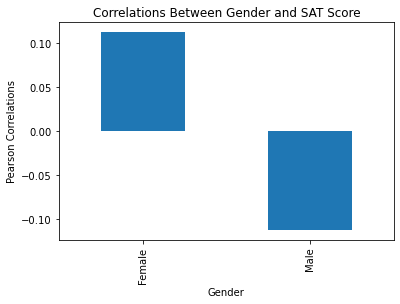

In [22]:
# plot gender vs. sat score
gender_cols = ['female_per', 'male_per']
gender_ticks = ['Female', 'Male']
fig = combined.corr()['sat_score'][gender_cols].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Gender')
fig.set_xticklabels(gender_ticks)
fig.set_title('Correlations Between Gender and SAT Score')

It looks like overall, girls score better on the SAT than boys do (though the correlation isn't particularly strong). Let's break this down by section.

Text(0.5, 1.0, 'Correlations Between Gender and SAT Writing Score')

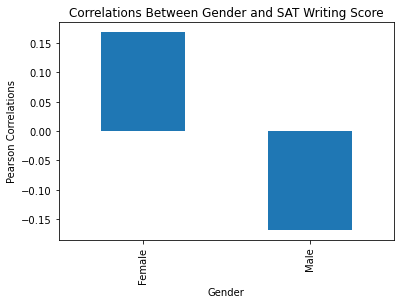

In [43]:
# plot gender vs. sat writing
sat_cols = ['SAT Writing Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score']
fig = combined.corr()['SAT Writing Avg. Score'][gender_cols].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Gender')
fig.set_xticklabels(gender_ticks)
fig.set_title('Correlations Between Gender and SAT Writing Score')

Text(0.5, 1.0, 'Correlations Between Gender and SAT Reading Score')

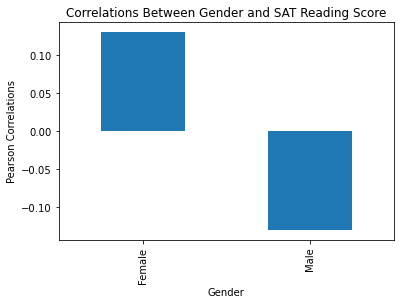

In [44]:
# plot gender vs. sat reading
sat_cols = ['SAT Writing Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score']
fig = combined.corr()['SAT Critical Reading Avg. Score'][gender_cols].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Gender')
fig.set_xticklabels(gender_ticks)
fig.set_title('Correlations Between Gender and SAT Reading Score')

Text(0.5, 1.0, 'Correlations Between Gender and SAT Math Score')

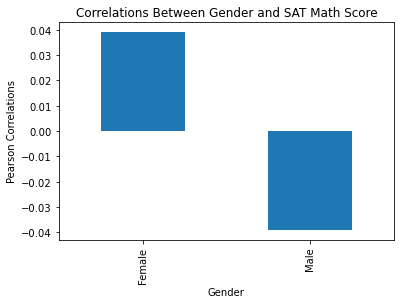

In [45]:
# plot gender vs. sat math
sat_cols = ['SAT Writing Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score']
fig = combined.corr()['SAT Math Avg. Score'][gender_cols].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Gender')
fig.set_xticklabels(gender_ticks)
fig.set_title('Correlations Between Gender and SAT Math Score')

As we can see from the above, the positive correlation is strongest for writing and weakest for math. However, none is particularly strong. Next, let's create a scatterplot of percentage of female students and average SAT score.

Text(0.5, 1.0, 'Female Population and SAT Score Scatterplot')

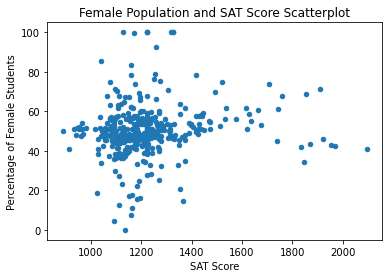

In [23]:
# scatter plot for female students & sat score
fig = combined.plot.scatter(x='sat_score', y='female_per')
fig.set_ylabel('Percentage of Female Students')
fig.set_xlabel('SAT Score')
fig.set_title('Female Population and SAT Score Scatterplot')

While there's no clear correlation here, there seems to be a cluster around low SAT score and roughly equal gender distributions. In addition, schools that are entirely or almost entirely female don't seem to have higher SAT scores.

In [24]:
high_fem_per = combined[(combined['female_per'] > 65.0) & (combined['sat_score'] > 1700)]
print(high_fem_per.loc[:, ['SCHOOL NAME', 'female_per', 'sat_score']].sort_values(by='female_per'))

SCHOOL NAME  female_per  sat_score
26                       ELEANOR ROOSEVELT HIGH SCHOOL        67.5     1758.0
5                       BARD HIGH SCHOOL EARLY COLLEGE        68.7     1856.0
302                        TOWNSEND HARRIS HIGH SCHOOL        71.1     1910.0
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...        73.6     1707.0


LaGuardia High School—the high school with the highest percentage of female students with an average SAT score over 1700—is a specialized magnet high school focusing on the arts. In addition to its academic curriculum, it has high-quality instruction in arts fields, including music and theatre.

Townsend Harris High School, which has the second-highest percentage of female students, is an elite high school not dissimilar from Stuyvesant and the like. It's ranked first in New York City and New York State according to U.S. News and World Report (Stuyvesant's #1 ranking comes from Niche) and #5 in the nation.

Next, let's investigate the relationship between APs and SAT score.

In [25]:
# create column for percent of students who took an AP test
combined['ap_per'] = (round(combined['AP Test Takers '] / combined['total_enrollment'], 4)) * 100

In [26]:
# show schools with bottom and top five AP test taker percentages
print('Fewest AP test takers:\n', combined.loc[:, ['SCHOOL NAME', 'ap_per']].sort_values(by='ap_per').head())
print('Most AP test takers:\n', combined.loc[:, ['SCHOOL NAME', 'ap_per']].sort_values(by='ap_per', ascending=False).head())

Fewest AP test takers:
                                            SCHOOL NAME  ap_per
329            YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS    1.18
220                         BOYS AND GIRLS HIGH SCHOOL    1.35
101  ALFRED E. SMITH CAREER AND TECHNICAL EDUCATION...    1.49
47           THE URBAN ASSEMBLY NEW YORK HARBOR SCHOOL    1.63
196                 JUAN MOREL CAMPOS SECONDARY SCHOOL    1.85
Most AP test takers:
                                            SCHOOL NAME  ap_per
335                            CAMBRIA HEIGHTS ACADEMY   87.77
111                          BRONX BRIDGES HIGH SCHOOL   83.24
222             THE BROOKLYN ACADEMY OF GLOBAL FINANCE   81.15
208                            FRANCES PERKINS ACADEMY   74.58
6    47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...   74.15


Text(0, 0.5, 'Percentage of AP Test Takers')

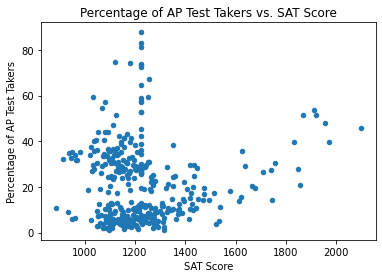

In [27]:
# AP percentage – SAT score scatterplot
fig = combined.plot.scatter(x='sat_score', y='ap_per')
fig.set_title('Percentage of AP Test Takers vs. SAT Score')
fig.set_xlabel('SAT Score')
fig.set_ylabel('Percentage of AP Test Takers')

The percentage of AP test takers does not seem to correlate strongly with higher SAT scores. However, there's a cluster near low- to low-medium SAT Scores and low- to low-medium AP test takers.

Next, we'll look at the correlations between average class size and SAT score.

In [28]:
# find correlations between average class size and SAT score
print(combined['AVERAGE CLASS SIZE'].head())

0    22.564286
1    22.231250
2    21.200000
3    23.571429
4    25.510526
Name: AVERAGE CLASS SIZE, dtype: float64


Text(0.5, 1.0, 'Correlations Between Class Size, Total Enrollment, and SAT Score')

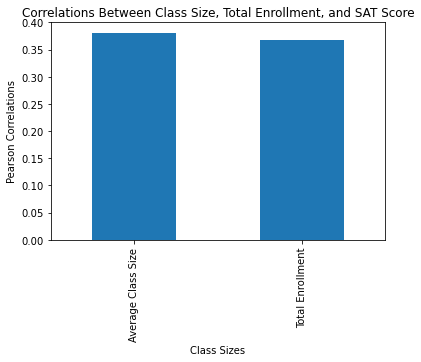

In [29]:
class_size_cols = ['AVERAGE CLASS SIZE',
                 'total_enrollment']
class_size_ticks = ['Average Class Size',
                    'Total Enrollment']
fig = combined.corr()['sat_score'][class_size_cols].plot.bar()
fig.set_ylabel('Pearson Correlations')
fig.set_xlabel('Class Sizes')
fig.set_xticklabels(class_size_ticks)
fig.set_title('Correlations Between Class Size, Total Enrollment, and SAT Score')

Both average class size and total enrollment seem to be correlated with SAT score. This may be related to the possible explanations we outlined above.